<a href="https://colab.research.google.com/github/hasibzunair/learn-pytorch/blob/master/notebooks/examples/03_transferlearning_vgg16_cifar10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Example (VGG16 pre-trained on ImageNet for Cifar-10)

Adapted from https://github.com/rasbt/deeplearning-models

In [1]:
!pip install torch-summary

In [2]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from torchsummary import summary

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/vision/stable/models.html
from torchvision import models
#######################################

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Loading an Example Dataset

In this example, we are going to work with CIFAR-10, because it's small (smaller) than ImageNet and fast to downliad. However, note that in a "real-world application", images with dimension > 224x224 are recommended when working with modelsthat have been trained on ImageNet images with > 224x224 size. Here, we resize the images as a workaround.

- Note that due to the average pooling in the final layer, it is also possible to feed in 32x32-pixel images directly. However, I noticed that the performance is rather low (~65% test accuracy after 10 and 100 epochs).

- Also note that we we normalize the images with the following parameters

```
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
```

which have been used for training the model originally on ImageNet.

In [3]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
learning_rate = 0.0001
num_epochs = 10
batch_size = 128


##########################
### MNIST DATASET
##########################

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean and std computed from ImageNet dataset
                          std=[0.229, 0.224, 0.225])
])

## Note that this particular normalization scheme is
## necessary since it was used for pre-training
## the network on ImageNet.
## These are the channel-means and standard deviations
## for z-score normalization.


train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0



Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


## Loading the Pre-Trained Model

Here, we are going to use VGG16 as an example for transfer learning from `torchvision`. A list of all pre-trained models is available at

- https://pytorch.org/docs/stable/torchvision/models.html

In [4]:
model = models.vgg16(pretrained=True)
model

# all pretrained model in pytorch are normalized using
# always using this normalizer prior passing an image through the model
# transforms.Normalize(mean=[0.485, 0.456, 0.406]
#                      std=[0.229, 0.224, 0.225])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Freezing the Model

First, we are going to freeze the whole model:

In [5]:
# Freeze whole model
for param in model.parameters():
    param.requires_grad = False

## Unfreeze classification block layers

In [6]:
# Unfreeze all layers in classification block

# for parameter in model.classifier.parameters():
#     parameter.requires_grad = True

In [7]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Now, replace the output layer with your own output layer (here, we actually add two more output layers):

In [8]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, NUM_CLASSES))
#print(model)

In [9]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

In [10]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  136363338
Trainable parameters  2102794


## Training (as usual)

In [11]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

In [12]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

KeyboardInterrupt: ignored

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test accuracy: 82.79%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(predicted_labels)

128

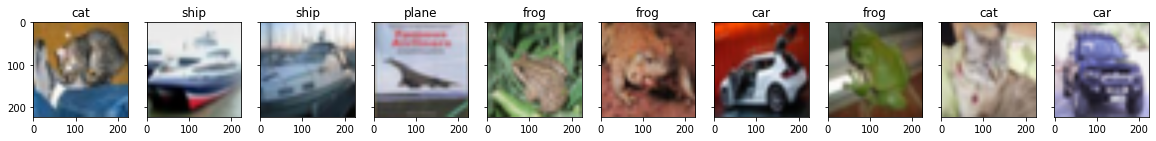

In [ ]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]), # ImageNet mean and std
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])